In [1]:
# Install required packages.
import os
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import plotly.express as px
import plotly.io as pio

import itertools
from sklearn.decomposition import PCA

## _ General Functions

In [2]:
def create_color_map_with_roomtype(graph):
    color_map = []
    mergeid_colors = {
        "bath": '#FFE953',
        "kitchen": '#9A5387',
        "living": '#ED6D87',
        "bed": '#5B448C',
        "foyer": '#ED6D87',
        "extra": '#FF9FBB'
    }

    for node in graph.nodes():
        mergeid = graph.nodes[node].get('mergeid', None)
        if node == 'root':
          color_map.append('#696969')
        elif mergeid and mergeid in mergeid_colors:
          color_map.append(mergeid_colors[mergeid])
        else:
            color_map.append('#BEBEBE')  # Color for nodes with degree > 1

    return color_map

In [3]:
def numberOfRoomNodes(graph):
    color_map = []
    mergeid_colors = {
        "bath": '#FFE953',
        "kitchen": '#9A5387',
        "living": '#ED6D87',
        "bed": '#5B448C',
        "foyer": '#ED6D87',
        "extra": '#FF9FBB'
    }
    numSubdNodes = 0
    numRoomNodes = 0

    degreeSubd = []
    degreeRoom = []

    degreeDict = graph.degree()

    for node in graph.nodes():
        
        mergeid = graph.nodes[node].get('mergeid', None)
        val = degreeDict[node]
        if node == 'root':
          color_map.append('#696969')
          numSubdNodes+=1
          degreeSubd.append(val)
        elif mergeid and mergeid in mergeid_colors:
          color_map.append(mergeid_colors[mergeid])
          numRoomNodes+= 1
          degreeRoom.append(val)
        else:
            color_map.append('#BEBEBE')  # Color for nodes with degree > 1
            numSubdNodes+=1
            degreeSubd.append(val)

    return [numSubdNodes, numRoomNodes, degreeSubd, degreeRoom]

In [4]:
def add_nodes_edges(graph, data):
    name = data["name"]
    area = data["area"]
    angle = data["angle"]
    mergeid = data["mergeid"]
    graph.add_node(name, area=area, angle=angle, mergeid=mergeid)

    children = data["children"]
    for child in children:
        child_name = child["name"]
        child_area = child["area"]
        child_angle = child["angle"]
        child_mergeid = child["mergeid"]
        graph.add_node(child_name, area=child_area, angle=child_angle, mergeid=child_mergeid)
        graph.add_edge(name, child_name)
        add_nodes_edges(graph, child)

In [5]:
def add_hypergraph(graph, data):
    if 'name' in data:
        node_name = data['name']
        graph.add_node(node_name, **data)
        if 'connected' in data:
            connected_nodes = data['connected']
            for connected_node in connected_nodes:
                # Add an adjacency edge between the current node and the connected node
                graph.add_edge(node_name, connected_node, type='adjacency')
        if 'children' in data:
            for child in data['children']:
                child_name = child['name']
                # Add a subdivision edge between the current node and the child node
                graph.add_edge(node_name, child_name, type='subdiv')
                add_hypergraph(graph, child)



In [6]:
def display_single_graph(dfX, i):
    graph = dfX['graph'][i]
    id = dfX['id'][i]
    city = dfX['city'][i]
    area = dfX['area'][i]
    bedrooms = dfX['bedrooms'][i]
    subd = dfX['graph_detail_subd'][i]
    adj = dfX['graph_detail_adj'][i]

    display_graph(graph, subd, adj, id, city, area, bedrooms)

In [7]:
def display_graph(graph, subd, adj, id, city, area, bedrooms, ax):
    # create color map with room type colors
    color_map = create_color_map_with_roomtype(graph)

    # Filter edges by type 'subdiv'
    subdiv_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'subdiv']

    # Create a subgraph with only the 'subdiv' edges
    subgraph = graph.edge_subgraph(subdiv_edges)
    layout = nx.kamada_kawai_layout(subgraph)  # or nx.shell_layout(subgraph)

    # Find the root node with mergeid 'root'
    root_node = None
    for node, data in graph.nodes(data=True):
        if data.get('mergeid', None) == 'root':
            root_node = node
            break

    if root_node is not None:
        # Calculate the distances from each node to the root node
        distances = nx.shortest_path_length(graph, target=root_node)
        max_distance = max(distances.values())

        # Draw the edges
        for u, v, edge_data in graph.edges(data=True):
            edge_type = edge_data.get('type', None)
            if edge_type == 'subdiv':
                # Determine the distances from the current nodes to the root node
                u_distance = distances[u]
                v_distance = distances[v]

                # Calculate the line width based on the distances
                line_width_u = 3 + (max_distance - u_distance) * 2
                line_width_v = 3 + (max_distance - v_distance) * 2

                # Draw the line with dotted style and scaled width
                nx.draw_networkx_edges(graph, pos=layout, edgelist=[(u, v)], edge_color='#E6E6E6',
                                       width=max(line_width_u, line_width_v), ax=ax)
            elif edge_type == 'adjacency':
                # Draw the line with grey color and width 2
                nx.draw_networkx_edges(graph, pos=layout, edgelist=[(u, v)], edge_color='black', width=1.5,
                                       style='dotted', ax=ax)

    # Draw the nodes with labels
    node_sizes = [node_data['area'] * 10 for _, node_data in graph.nodes(data=True)]
    nx.draw_networkx_nodes(graph, pos=layout, node_color=color_map, edgecolors='black', linewidths=0.5,
                           node_size=node_sizes, ax=ax)

    # Set the title for the subplot
    ax.set_title(f"N Subdivision: {subd} \n N Adjacency: {adj}\nID: {id}\n City: {city}\nArea: {round(area, 2)} m2\nBedrooms: {bedrooms}")

    # Remove the axis labels
    ax.axis('off')

# Load Data

In [21]:
df = pd.read_json('src/sample_hypergraphs.json')
df
# Create a new column for the graphs
df['graph'] = None

# Iterate over each value in df['split']
for i, split_value in enumerate(df['split']):
    # Load the JSON data
    data = json.loads(split_value)

    # Create an empty graph
    graph = nx.Graph()

    # Recursively add nodes and edges
    add_hypergraph(graph, data)

    # Save the graph in the DataFrame
    df.at[i, 'graph'] = graph

In [22]:
df_graph_num_adjEdges = []
df_graph_num_subdEdges = []

for i, row in df.iterrows():
    graph = df['graph'][i]

    # Filter edges by type 'subdiv'
    subdiv_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'subdiv']
    df_graph_num_subdEdges.append(len(subdiv_edges))

    # Filter edges by type 'subdiv'
    adj_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'adjacency']
    df_graph_num_adjEdges.append(len(adj_edges))

# Create a new column for the graphs
df['graph_detail_adj'] = None
# Iterate over each value in df['split']
for i, split_value in enumerate(df['split']):
    # Save the graph in the DataFrame
    df.at[i, 'graph_detail_adj'] = df_graph_num_adjEdges[i]

# Create a new column for the graphs
df['graph_detail_subd'] = None
# Iterate over each value in df['split']
for i, split_value in enumerate(df['split']):
    # Save the graph in the DataFrame
    df.at[i, 'graph_detail_subd'] = df_graph_num_subdEdges[i]

# Visualize Single Hypergraph

In [27]:
# Choose which reference graph to visualize from dataframe
i=2

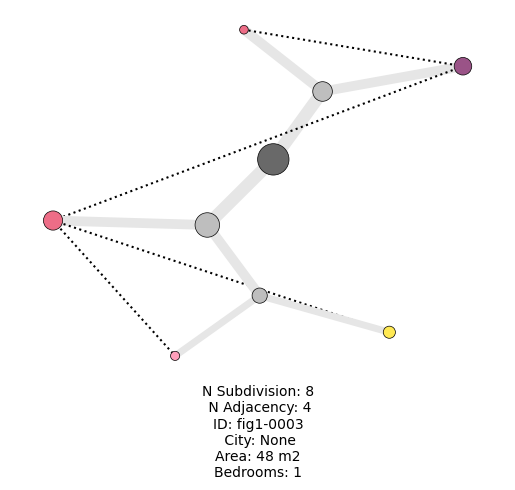

In [28]:
graph = df['graph'][i]
id = df['id'][i]
city = df['city'][i]
area = df['area'][i]
subd = df['graph_detail_subd'][i]
adj = df['graph_detail_adj'][i]
bedrooms = df['bedrooms'][i]

# create color map with room type colors
color_map = create_color_map_with_roomtype(graph)

# Filter edges by type 'subdiv'
subdiv_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'subdiv']

# Create a subgraph with only the 'subdiv' edges
subgraph = graph.edge_subgraph(subdiv_edges)
layout = nx.kamada_kawai_layout(subgraph)  # or nx.shell_layout(subgraph)

# 0001 B Draw all edges using the layout from the subgraph
# Find the root node with mergeid 'root'
root_node = None
for node, data in graph.nodes(data=True):
    if data.get('mergeid', None) == 'root':
        root_node = node
        break

if root_node is not None:
    # Calculate the distances from each node to the root node
    distances = nx.shortest_path_length(graph, target=root_node)
    max_distance = max(distances.values())

    # Draw the edges
    for u, v, edge_data in graph.edges(data=True):
        edge_type = edge_data.get('type', None)
        if edge_type == 'subdiv':
            # Determine the distances from the current nodes to the root node
            u_distance = distances[u]
            v_distance = distances[v]

            # Calculate the line width based on the distances
            line_width_u = 3 + (max_distance - u_distance)*2
            line_width_v = 3 + (max_distance - v_distance)*2

            # Draw the line with dotted style and scaled width
            nx.draw_networkx_edges(graph, pos=layout, edgelist=[(u, v)], edge_color='#E6E6E6', width=max(line_width_u, line_width_v))
        elif edge_type == 'adjacency':
            # Draw the line with grey color and width 2
            nx.draw_networkx_edges(graph, pos=layout, edgelist=[(u, v)], edge_color='black', width=1.5, style='dotted')



# Draw the nodes with labels
node_sizes = [node_data['area']*10 for _, node_data in graph.nodes(data=True)]
nx.draw_networkx_nodes(graph, pos=layout, node_color=color_map, edgecolors='black', linewidths=0.5, node_size=node_sizes)

# Display the graph
hfont = {'fontname':'sans-serif'}
plt.xlabel(f"N Subdivision: {subd}\n N Adjacency: {adj}\nID: {id}\n City: {city}\nArea: {round(area, 2)} m2\nBedrooms: {bedrooms}", **hfont)

plt.box(False)

plt.show()

In [15]:
current_graph = df['graph'][1]
nx.normalized_laplacian_spectrum(current_graph, weight='weight')

array([-1.03423260e-17,  4.46734505e-01,  6.58766902e-01,  1.33333333e+00,
        1.33333333e+00,  1.51874220e+00,  1.70908972e+00])

# Compute graph properties

In [17]:
df2 = df

# Create a new column for the graphs
df2['graph'] = None
df2['degree_sequence'] = None
df2['degree_sorted'] = None
df2['graph_detail_adj'] = None
df2['graph_detail_subd'] = None
df2['degree_adjacent'] = None
df2['degree_subdiv'] = None

# For PCA 
df2['p0_numRooms'] = None          # -	Number of adjacency edges / number of rooms
df2['p1_numAdjEdges'] = None       # -	Number of adjacency edges / number of rooms  shows connected vs. linear fp
df2['p2_numSubdNodes'] = None      # -	Number of subdivision nodes / number of rooms 
df2['p3_degreeSum'] = None         # -	Sum(Degree of subdivision nodes) / number of rooms or better number of subdivision nodes?
df2['p4_numRoomNodes'] = None      # -	Number of room nodes / number of rooms
df2['p5_sumAdj'] = None            # -	Sum(Degree of adjacency edges) / Number of adjacency edges

# Iterate over each value in df['split']
for i, split_value in enumerate(df2['split']):
    # Load the JSON data
    data = json.loads(split_value)

    # Create an empty graph
    graph = nx.Graph()

    # Recursively add nodes and edges
    add_hypergraph(graph, data)

    # Save the graph in the DataFrame
    df2.at[i, 'graph'] = graph


    # Filter edges by type 'subdiv'
    subdiv_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'subdiv']
    df2.at[i, 'graph_detail_subd'] = len(subdiv_edges)

    # Filter edges by type 'adjacency'
    adj_edges = [(u, v) for u, v, edge_data in graph.edges(data=True) if edge_data['type'] == 'adjacency']
    df2.at[i, 'graph_detail_adj'] = len(adj_edges)

    # Recursively add nodes and edges
    degree_sorted = sorted((d for n, d in graph.degree()), reverse=True)
    degree_sequence = list(d for n, d in graph.degree())

    # Save the degree sequence in the DataFrame
    df2.at[i, 'degree_sequence'] = degree_sequence

    #degree_adjacent = sorted((d for n, d in graph.degree() if edge_data['type'] == 'adjacency'), reverse=True)
    #df2.at[i, 'degree_adjacent'] = degree_adjacent


    #--------------------------------------------------------
    numList = numberOfRoomNodes(graph) # num subd nodes, num roomNodes, degree subd nodes, degree roomnodes
    numSubdNodes = numList[0]
    numRoomNodes = numList[1]

    degree_subdivison_nodes = numList[2]
    df2.at[i, 'degree_subdiv'] = degree_subdivison_nodes
    
    degree_room_nodes = numList[3]
    df2.at[i, 'degree_adjacent'] = degree_room_nodes


    numRoomsNorm = df2.at[i, 'bedrooms']
    df2.at[i,'p0_numRooms'] = numRoomsNorm                              # -	Num rooms
    df2.at[i,'p1_numAdjEdges'] = len(adj_edges)   # / numRoomsNorm          # -	Number of adjacency edges / number of rooms  shows connected vs. linear fp
    df2.at[i,'p2_numSubdNodes'] = numSubdNodes    #/ numRoomsNorm           # -	Number of subdivision nodes / number of rooms 
    df2.at[i,'p3_degreeSum'] = sum(degree_sorted) #/ numRoomsNorm        # -	Sum(Degree of subdivision nodes) / number of rooms or better number of subdivision nodes?
    df2.at[i,'p4_numRoomNodes'] = numRoomNodes       # -	Number of room nodes / number of rooms
    df2.at[i,'p5_sumAdj'] = sum(degree_room_nodes) #/ numRoomNodes       # -	Sum(Degree of adjacency edges) / Number of adjacency edges

,database,id,country,city,name,area,bedrooms,bathrooms,bounds,facade,...,degree_sequence,degree_sorted,degree_adjacent,degree_subdiv,p0_numRooms,p1_numAdjEdges,p2_numSubdNodes,p3_degreeSum,p4_numRoomNodes,p5_sumAdj
0,reference,fig1-0001,None,None,Sample A,48,1,1,"{""corners"":[{""X"":-23.691424548990707,""Y"":-142....","[{""start"":{""X"":-23.691424548990707,""Y"":-142.65...",...,"[2, 3, 3, 3, 3, 2, 2, 3, 3]",None,"[3, 3, 2, 2, 3]","[2, 3, 3, 3]",1,4,4,24,5,13
1,reference,fig1-0002,None,None,Sample B,48,1,1,"{""corners"":[{""X"":-23.691424548990707,""Y"":-142....","[{""start"":{""X"":-23.691424548990707,""Y"":-142.65...",...,"[2, 3, 2, 4, 3, 3, 3]",None,"[2, 4, 3, 3]","[2, 3, 3]",1,4,3,20,4,12
2,reference,fig1-0003,None,None,Sample C,48,1,1,"{""corners"":[{""X"":-23.691424548990707,""Y"":-142....","[{""start"":{""X"":-23.691424548990707,""Y"":-142.65...",...,"[2, 3, 3, 2, 4, 3, 2, 2, 3]",None,"[3, 2, 4, 2, 2]","[2, 3, 3, 3]",1,4,4,24,5,13
3,reference,fig1-0004,None,None,Sample D,48,1,1,"{""corners"":[{""X"":-23.691424548990707,""Y"":-142....","[{""start"":{""X"":-23.691424548990707,""Y"":-142.65...",...,"[2, 3, 2, 3, 2, 3, 3, 3, 3, 4, 2]",None,"[2, 3, 2, 3, 4, 2]","[2, 3, 3, 3, 3]",1,5,5,30,6,16
4,reference,fig1-0005,None,None,Sample E,48,1,1,"{""corners"":[{""X"":-23.691424548990707,""Y"":-142....","[{""start"":{""X"":-23.691424548990707,""Y"":-142.65...",...,"[2, 3, 2, 3, 5, 3, 3, 3, 2, 2, 2]",None,"[2, 3, 5, 2, 2, 2]","[2, 3, 3, 3, 3]",1,5,5,30,6,16
